In [1]:
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates

pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 40)

df = pandas.read_csv('./../data/USD000UTSTOM-20220512.csv', sep=',')
# df

In [2]:
df.time = pd.to_datetime(df.time)
# df.price = pd.to_numeric(df.price)
df.quantity = pd.to_numeric(df.quantity)

In [4]:
#кластера за ТФ
time_quantity = df.groupby([pd.Grouper(key='time', freq='1min'), 'price'])[['quantity']].sum()
# time_quantity

In [6]:
#максимумы в кластерах за ТФ
time_quantity.reset_index(level='time').groupby('time')['quantity'].idxmax().reset_index(name='price')

,time,price
0,2022-05-12 06:59:00+00:00,66.93
1,2022-05-12 07:00:00+00:00,66.50
2,2022-05-12 07:01:00+00:00,66.50
3,2022-05-12 07:02:00+00:00,66.43
4,2022-05-12 07:03:00+00:00,66.68
...,...,...
536,2022-05-12 15:55:00+00:00,63.40
537,2022-05-12 15:56:00+00:00,63.35
538,2022-05-12 15:57:00+00:00,63.30
539,2022-05-12 15:58:00+00:00,63.30


In [5]:
# макс объем за период
s = df.groupby(pd.Grouper(key='time', freq='1Min')).quantity.idxmax()
out = df.loc[s].set_index(['time'])
# out

In [6]:
time_quantity = df.groupby([pd.Grouper(key='time', freq='1min'), 'price'])[['quantity']].sum()
result = time_quantity.reset_index(level='time').groupby('time')['quantity'].idxmax().reset_index(name='price')
# result

In [7]:
grouped = df.set_index(['time'])
candles = grouped['price'].resample('1Min').ohlc()
candles = candles[['open', 'close', 'high', 'low']]
# candles

In [9]:
data = candles[:40]

# процентное соотношение лонгистов/шортистов в свече
difference = data['high'] - data['low']
long_ratio = (data['close'] - data['low']) / difference * 100
short_ratio = (data['high'] - data['close']) / difference * 100

ratio_df = pd.DataFrame(columns=['long', 'short'])
ratio_df['long'] = long_ratio
ratio_df['short'] = short_ratio

# расчет расположения макс. объема относительно открытия свечи
from_high = abs(data['high'] - data['max_volume_price'])
from_low = abs(data['max_volume_price'] - data['low'])
total = from_high + from_low
ratio_df.loc[data['direction'] == 1, 'percent'] = from_low / total * 100
ratio_df.loc[data['direction'] == 2, 'percent'] = from_high / total * 100

ratio_df['direction'] = data['direction']
ratio_df['time'] = data['time']

# определение победителя: 
# если соотношение лонгистов больше и макс объем как можно ниже, то приоритет для лонга
# если соотношение шортистов больше и макс объем как можно выше, то приоритет для шорта
ratio_df.loc[ratio_df['direction'] == 1, 'win'] = (ratio_df['long'] > 50) & (ratio_df['percent'] <= 40)
ratio_df.loc[ratio_df['direction'] == 2, 'win'] = (ratio_df['short'] > 50) & (ratio_df['percent'] <= 40)

# ratio_df

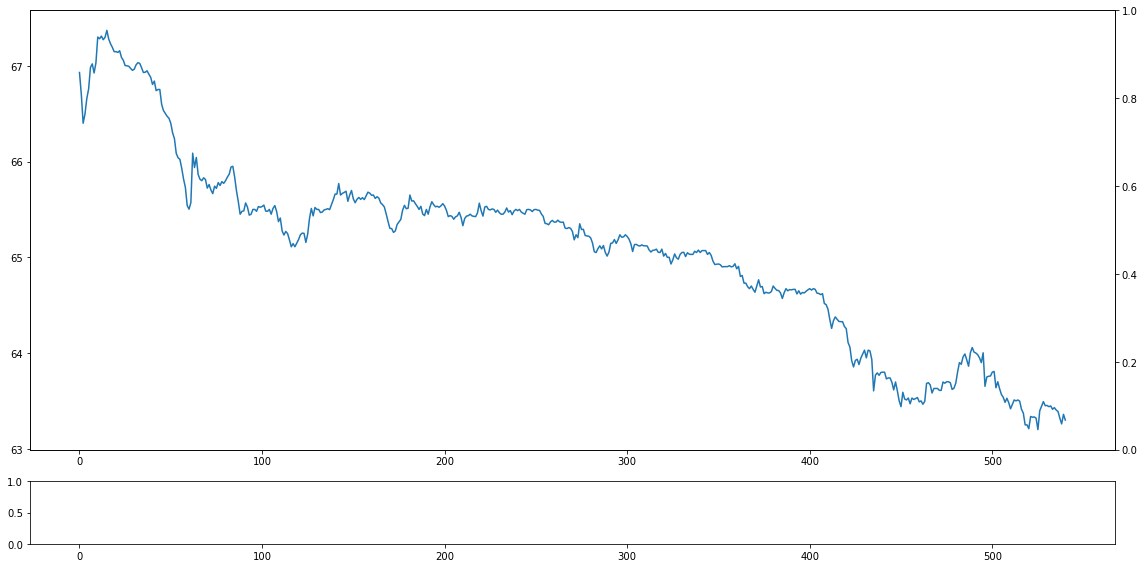

In [11]:
# chart
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax3 = ax1.twinx()
fig.tight_layout()

ax1.clear()
ax1.plot(candles.index, candles['close'])
plt.show(block=False)

In [3]:
# merge df
new_df = pandas.read_csv('./../data/temp/SBER-20220506.csv', sep=',')
new_df.time = pd.to_datetime(new_df.time)

source_df = pandas.read_csv('./../data/SBER-20220506.csv', sep=',')
source_df.time = pd.to_datetime(source_df.time)

first_time = new_df.iloc[0]['time']
last_time = new_df.iloc[-1]['time']
search_condition = (source_df['time'] >= first_time) & (source_df['time'] <= last_time)

result_df = source_df.drop(source_df.loc[search_condition].index)
result_df = pd.concat([result_df, new_df]).rename_axis('index')
result_df = result_df.sort_values(['time', 'index']).reset_index(drop=True)

result_df.to_csv('./../data/SBER-20220506-merge-test.csv', mode='a', header=True, index=False)

In [13]:
import numpy as np
pd.set_option("max_rows", None)

df1 = pandas.read_csv('./../data/USD000UTSTOM-20220512.csv', sep=',')
df1.time = pd.to_datetime(df1.time)
df1.price = pd.to_numeric(df1.price)
df1.quantity = pd.to_numeric(df1.quantity)

def agg_ohlcv(x):
    if x.empty:
        return pd.Series({
            'low': 0,
            'high': 0,
            'open': 0,
            'close': 0,
            'total_volume': 0,
            'max_volume_price': 0
        })
    
    price = x['price'].values
    quantity = x['quantity'].values
    return pd.Series({
        'low': min(price),
        'high': max(price),
        'open': price[0],
        'close': price[-1],
        'total_volume': sum(quantity),
        'max_volume_price': x.groupby(['price'])[['quantity']].sum().idxmax()[0]
    })
candles = df1.set_index(['time'])
candles = candles.resample('1min').apply(agg_ohlcv)
candles = candles.ffill()

candles.loc[candles['close'] == candles['open'], 'direction'] = 0 # свеча доджи
candles.loc[candles['close'] > candles['open'], 'direction'] = 1 # бычья свеча
candles.loc[candles['open'] > candles['close'], 'direction'] = 2 # медвежья свеча
candles['time'] = candles.index

candles = candles[['time', 'open', 'close', 'high', 'low', 'total_volume', 'direction', 'max_volume_price']]
candles = candles.reset_index(drop=True)

# candles